In [26]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import json
import os
from PIL import Image, ImageDraw, ImageOps
from IPython.display import display

In [27]:
class ClimbingHoldDataset(Dataset):
    def __init__(self, annotations_dir, images_dir, transform=None, output_size=(128, 128)):
        """
        annotations_dir: Directory containing multiple JSON annotation files
        images_dir: Directory where images are stored
        transform: Transformations to apply to the image (e.g., resize, normalization)
        output_size: Size to resize cropped images (width, height)
        """
        self.images_dir = images_dir
        self.transform = transform
        self.output_size = output_size

        # Initialize an empty list to store all holds from all JSON files
        self.holds = []

        # Iterate over all JSON files in the annotations directory
        for json_file in os.listdir(annotations_dir):
            if json_file.endswith(".json"):
                json_path = os.path.join(annotations_dir, json_file)

                # Load the JSON file
                with open(json_path, 'r') as file:
                    data = json.load(file)

                # Extract information from the JSON file
                images = {img['id']: img['file_name'] for img in data.get('images', [])}
                annotations = data.get('annotations', [])
                difficulties = {cat['id']: cat['name'] for cat in data.get('categories', [])}

                for annotation in annotations:
                    file_name = images.get(annotation.get("image_id"))
                    hold_data = {
                        "image_id": file_name,
                        "difficulty": difficulties.get(annotation.get("category_id")),
                        "type": annotation["attributes"].get("Type"),
                        "orientation": annotation["attributes"].get("Orientation"),
                        "bbox": annotation.get("bbox"),
                        "segmentation": annotation.get("segmentation"),
                    }
                    # Store each hold as a separate entry
                    self.holds.append(hold_data)

    def __len__(self):
        return len(self.holds)

    def __getitem__(self, idx):
        # Get the hold data for the current index
        hold_data = self.holds[idx]
        image_id = hold_data["image_id"]
        image_path = os.path.join(self.images_dir, image_id)
        image = Image.open(image_path)

        # Apply rotation if required (optional)
        # rotated_image = image.rotate(-90, expand=True)
        rotated_image = ImageOps.exif_transpose(image)

        # Extract the bounding box (x_min, y_min, width, height)
        bbox = hold_data["bbox"]
        x_min, y_min, width, height = bbox

        # Crop the image using the bounding box
        cropped_image = rotated_image.crop((x_min, y_min, x_min + width, y_min + height))

        # Resize the cropped image to the fixed output size (e.g., 128x128 or 224x224)
        cropped_image = cropped_image.resize(self.output_size)

        # Apply any additional transformations (e.g., normalization) if defined
        if self.transform:
            cropped_image = self.transform(cropped_image)

        # Map labels to indices for classification tasks
        hold = {
            "image": cropped_image,
            "type": self._map_type(hold_data["type"]),
            "orientation": self._map_orientation(hold_data["orientation"]),
        }

        return hold

    def _map_type(self, type_label):
        types = ['Jug', 'Sloper', 'Crimp', 'Jib', 'Pinch', 'Pocket', 'Edge']
        return types.index(type_label) if type_label in types else -1

    def _map_orientation(self, orientation_label):
        orientations = ['Up', 'Down', 'Side', 'UpAng', 'DownAng']
        return orientations.index(orientation_label) if orientation_label in orientations else -1


In [28]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to a standard size
    transforms.ToTensor(),          # Convert PIL image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization (ImageNet mean and std)
])

# Create the dataset
dataset = ClimbingHoldDataset(annotations_dir="data/annotations", 
                               images_dir="data/images", 
                               transform=transform)


Sample Hold from Training Set:


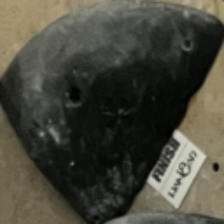


Sample Hold:
Image shape: torch.Size([3, 224, 224])
Hold Type (index): 0
Hold Orientation (index): 3


In [29]:
# Function to print one sample hold and its attributes
def print_sample_hold(dataset):
    # Get the first sample hold
    sample = dataset[0]
    
    # Denormalize the image
    mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).reshape(3,1,1)
    img = sample["image"] * std + mean
    img = img.clamp(0, 1)

    pil_img = transforms.ToPILImage()(img)

    display(pil_img)  # works in notebooks
    print("\nSample Hold:")
    print(f"Image shape: {sample['image'].shape}")
    print(f"Hold Type (index): {sample['type']}")
    print(f"Hold Orientation (index): {sample['orientation']}")

# Print one sample hold from both training and validation sets
print("\nSample Hold from Training Set:")
print_sample_hold(dataset)